Handle Raw Data
###

- *Expects*: PICKLE
- *Returns*: CSV

This file takes in the raw data, which has been downloaded from the server, and passed into the digital twin. It can then be downloaded from the download link. This is done for 2 reasons:
- To reduce processing memory requires on the server
- To use SQL to filter by date, and thus reduce memory load on analysis machines

Running the cells in this notebook will do the following:
- Clean the data and structure it into a per-participant format
- De-duplicate the data, according to pre-specified criteria [TODO]
- Parse the data into round-level data

In [30]:
import json
import pandas as pd
import urllib.parse
from collections import Counter
import numpy as np
import pickle

In [31]:
### PARAMETERS
# ------------

# Pickle path
picklePath = "C:/Users/agrog/Documents/Oxford/analysis/effugium/data/pickles/1706796228.pickle"
# The path to where the csv should be saved
csvPath = "C:/Users/agrog/Documents/Oxford/analysis/effugium/y2/rw_24_all.csv"
# Path to the duplicate file
duplicatesPath = "C:/Users/agrog/Documents/Oxford/analysis/effugium/y2/completeDuplicates.csv"
# Path to the scores = 
scoresPath = "C:/Users/agrog/Documents/Oxford/analysis/effugium/y2/y4scores.csv"
# ------------

In [32]:
# Open as pickle
with open(picklePath, 'rb') as handle:
    qs = pickle.load(handle)

jsonData = qs.decode('utf8').replace("'", '"')
data = json.loads(jsonData)

In [33]:
def clean(rawData):
    cleanData = {}
    for user in rawData:
        # pk = user['id']
        # user = userAll['fields']
        tmp = {
            'pk' : user['id'],
            'userId' : urllib.parse.quote(user['userId']),
            'rawData' : json.loads(user['rawData']),
            'sdata' : None,
            # 'edata' : user['edata'],
            # 'parameters' : user['parameters'],
            'totalAttempts' : None,
            'completed' : user['completeAttempt'],
            # 'lastCompletedRound' : None,
            # 'lastTrialGame' : None,
            # 'finalRooms' : [],
            'urlParameters' : user['urlParameters'],
            'timestamps' : [],
            'timeCreated' : user['timeCreated'],
            'lastModified' : user['lastModified']
        }
        # Check how many attempts the user has had
        tmp['totalAttempts'] = len(tmp['rawData'])
        # Store timestamp/s
        tmp['timestamps'] = list(tmp['rawData'].keys())
        # If it's one, check if it's complete
        if tmp['totalAttempts'] == 1:
            # Get the attempt timestamp
            timestamp = list(tmp['rawData'].keys())[0]
        elif tmp['totalAttempts'] > 1:
            # For multiple attempts, find the occurence with the highest number of completed trial_layouts
            indAttempts = [] # individual attempts
            for i in range(tmp['totalAttempts']):
                # Get the sdata for this timestamp, and get the length of the expt_index array
                try:
                    attNum = len(json.loads(tmp['rawData'][tmp['timestamps'][i]]['sdata'])['expt_index'])
                    indAttempts.append(attNum)
                except:
                    indAttempts.append(0)
            # Get the index of the value with the greatest magnitude
            timestamp = tmp['timestamps'][np.argmax(indAttempts)]
            
        # Use the timestamp to add sdata to tmp
        try:
            tmp['sdata'] = json.loads(tmp['rawData'][timestamp]['sdata'])
        except:
            if tmp['rawData'][timestamp]['sdata'] == None or len(tmp['rawData'][timestamp]['sdata']) == 0:
                tmp['sdata'] = None
        if tmp['sdata'] != None:
            # Check if complete by:
            #    - trial_layout == 92 or
            #    - trial_game == 80
            # if len(Counter(tmp['sdata']['trial_layout']).keys()) >= 92:
            if max(np.array(tmp['sdata']['trial_game'], dtype=np.float64)) >= 80:
                tmp['completed'] = True
                tmp['lastCompletedRound'] = len(tmp['sdata']['trial_game'])
            else:
                tmp['completed'] = False
                tmp['lastCompletedRound'] = len(Counter(tmp['sdata']['trial_layout']).keys())
            # Store how many trial_games they've seen
            tmp['lastTrialGame'] = int(tmp['sdata']['trial_game'][-1])
        else:
            tmp['completed'] = False
            tmp['lastCompletedRound'] = 0
            
        cleanData[tmp['pk']] = tmp
    print("Dataset ready.")
    return cleanData

In [5]:
def getRounds(cleanData, duplicateOrder=False):
    rounds = {}
    count = 0
    for user in cleanData:
        u = cleanData[user]
        us = u['sdata']
        if us is not None:
            for i in range(len(u['sdata']['expt_index'])):
                rounds[str(count)] = {
                    "pk" : u['pk'],
                    "id" : u['userId'],
                    "iv" : None if (u['urlParameters'] is None or u['urlParameters']['iv'] == None) else urllib.parse.quote(u['urlParameters']['iv']),
                    "tag" : None if (u['urlParameters'] is None or u['urlParameters']['tag'] == None) else urllib.parse.quote(u['urlParameters']['tag']),
                    "expt_index": us['expt_index'][i],
                    "expt_trial": us['expt_trial'][i],
                    "trial_layout" : us['trial_layout'][i],
                    "trial_level" : us['trial_level'][i],
                    "trial_solved" : us['trial_solved'][i],
                    "trial_attempts" : us['trial_attempts'][i],
                    "trial_game" : us['trial_game'][i],
                    "trial_transfer" : us['trial_transfer'][i],
                    "trial_test" : us['trial_test'][i],
                    "round_start_time" : None,
                    "round_end_time" : None,
                    "last_room" : None,
                    "roundAttempted" : None,
                    "gameComplete" : u["completed"],
                    "duplicateOrder" : u["duplicateOrder"] if duplicateOrder else -1,
                    "riseId" : u["riseId"],
                    "wasFirstComplete" : u["wasFirstComplete"],
                    "train" : u["train"],
                    "test" : u["test"],
                    "transfer" : u["transfer"],
                    "score" : u["score"]
                }

                # Insert start time, end time, and roundAttempted
                if len(us["resp"][str(i)]["timestamp"]) != 0:
                    # If an attempt has been made
                    rounds[str(count)]["round_start_time"] = us["resp"][str(i)]["timestamp"][0] - us["resp"][str(i)]["reactiontime"][0]
                    rounds[str(count)]["round_end_time"] = us["resp"][str(i)]["timestamp"][-1]
                    rounds[str(count)]["roundAttempted"] = True
                else:
                    rounds[str(count)]["roundAttempted"] = False
                    
                # Compute final room position as [x, y]. Scale is 0->10 and includes 2 walls
                if len(us["resp"][str(i)]["xloc"]) != 0 and len(us["resp"][str(i)]["yloc"]) != 0:
                    xloc = us["resp"][str(i)]["xloc"][-1]
                    yloc = us["resp"][str(i)]["yloc"][-1]
                    rounds[str(count)]["last_room"] = []
                    if xloc < 3:
                        rounds[str(count)]["last_room"].append(0)
                    elif 3 < xloc < 7:
                        rounds[str(count)]["last_room"].append(1)
                    elif 7 < xloc < 11:
                        rounds[str(count)]["last_room"].append(2)
                    if yloc < 3:
                        rounds[str(count)]["last_room"].append(0)
                    elif 3 < yloc < 7:
                        rounds[str(count)]["last_room"].append(1)
                    elif 7 < yloc < 11:
                        rounds[str(count)]["last_room"].append(2)
                    rounds[str(count)]["last_room"] = str(rounds[str(count)]["last_room"]).replace(",", "-")

                # Increase round count
                count += 1

    # Store as dataframe
    rounds = pd.DataFrame.from_dict(rounds, orient="index")

    return rounds


In [8]:
def processDuplicates(cleanData, format):
    """
    The most recent version of the deduplication process
    """
    duplicates = pd.read_csv(duplicatesPath)
    format = format.lower()
    assert format in ["None", None, "research", "rise", "all"], f"Unrecognised format for deduplication: {format} - allowed types are None, RISE, research, all. See docs for more information."
    # convert the cleanData from JSON to dataframe
    clean_df = pd.DataFrame.from_dict(cleanData, orient="index")
    # Make a list of riseId : [userIds] that contains single-players, and duplicate players
    counts = Counter(duplicates["USER_ID"])
    # map riseId to [userIds]
    ids = {id : list(duplicates.loc[duplicates["USER_ID"] == id]["ID"]) for id in counts}
    # Get only duplicate users
    duplicateHashes = {i : ids[i] for i in ids if len(ids[i]) >= 2}
    print(f"# Unique players: {len(ids)} -- # of those who repeated: {len(duplicateHashes)}")

    riseAttempts = [] # the first complete if available - if not, the first incomplete
    researchAttempts = []
    allAttempts = [] # for debugging, not important
    # take the first complete attempt - if none found, take just the first incomplete attempt
    # for each attempt made by one individual, check if they completed
    mapping = []
    i = 0
    for attempt in ids:
        # Get a df for just this participant
        repeats = clean_df.loc[clean_df["userId"].isin(ids[attempt])]
        completes = repeats.loc[repeats["completed"] == True]
        if (len(repeats) == 0):
            continue
        if len(completes) == 0:
            # no completed attempts, take just the first attempt
            firstTimestamp = min(list(repeats["timeCreated"]))
            # Returns the hashed ID associated with the attempt
            riseAttempts.append(list(repeats.loc[repeats["timeCreated"] == firstTimestamp]["userId"])[0])
            # Store a lookup of this hashed ID and the unique attempt number it was
            mapping.append({"userId" : riseAttempts[-1], "uniqueAttemptNumber" : 0})
        elif len(completes) == 1:
            # if 1 complete attempt - NB: this could be in any position, not necessarily first attempted
            riseAttempts.append(list(completes["userId"])[0])
            timestamp = list(completes["timeCreated"])[0]
            # This complete may not be the first attempt, so let's see which attempt number it is
            # See which attempt number this is:
            #   - Sort the timestamps in order, and get the index of our timestamp in that list
            uniqueAttemptNumber = list(repeats["timeCreated"].sort_values()).index(timestamp)
            # Store a lookup of this hashed ID and the unique attempt number it was
            mapping.append({"userId" : riseAttempts[-1], "uniqueAttemptNumber" : uniqueAttemptNumber})
        else:
            # if multiple complete attempts found - take the first for rise
            firstTimestamp = min(list(completes["timeCreated"]))
            riseAttempts.append(list(completes.loc[completes["timeCreated"] == firstTimestamp]["userId"])[0])
            # Store a lookup of this hashed ID and the unique attempt number it was
            mapping.append({"userId" : riseAttempts[-1], "uniqueAttemptNumber" : 0})

        # if more than one attempt, save which attempt number in total this is
        if len(repeats) > 1:
            # order the creation timestamps
            repeats["timeCreated"].sort_values()
            pass

        # For research purposes, we want to take only the very first attempt
        firstTimestamp = min(list(repeats["timeCreated"]))
        tmp = repeats.loc[repeats["timeCreated"] == firstTimestamp]["userId"]

        researchAttempts.append(list(tmp)[0])
        allAttempts.append(ids[attempt])
        print(repeats.head())

        i += 1
        if i == 2:
            break

        # sort the repeats dict by time order
        ixs = []
        for ix, i in enumerate(repeats.iterrows()):
            ixs.append(ix+1)

        return repeats.sort_values(by="timeCreated")

    if format == "rise":
        # merge the id : unique attempt number mapping
        mapping_df = pd.DataFrame.from_dict(mapping)
        # keep only the rise ones in cleanData
        return clean_df.loc[clean_df["userId"].isin(list(riseAttempts))].merge(mapping_df)
            
    elif format == "research":
        # keep only the research ones in cleanData
        return clean_df.loc[clean_df["userId"].isin(researchAttempts)]

In [6]:
def getResponses(cleanData, asDf = True):
    """
    Get responses from clean data dict. Clean data must be in dict form, not as pandas dataframe.
    """
    count = 0
    responses = {}
    for game in cleanData:
        # Get responses dict, containing responses for each round
        if cleanData[game]['sdata'] != None:
            resp = cleanData[game]['sdata']['resp'] # Check for Nonetype
            for r in resp:
                # Iterate over each move in the round r
                for move in range(len(resp[r]['timestamp'])):
                    responses[count] = {
                        "id" : cleanData[game]['userId'],
                        "pk" : cleanData[game]['pk'],
                        "round" : cleanData[game]['sdata']['expt_index'][int(r)],
                        "level" : cleanData[game]['sdata']['trial_level'][int(r)],
                        "layout" : cleanData[game]['sdata']['trial_layout'][int(r)],
                        "timestamp" : resp[r]['timestamp'][move],
                        "reactiontime" : resp[r]['reactiontime'][move],
                        "direction" : resp[r]['direction'][move],
                        "allowed" : resp[r]['allowed'][move],
                        "tool" : resp[r]['tool'][move],
                        "xloc" : resp[r]['xloc'][move],
                        "yloc" : resp[r]['yloc'][move],
                        "gameComplete" : cleanData[game]["completed"],
                        "roundSolved" : cleanData[game]['sdata']['trial_solved'][int(r)],
                    }
                    count += 1
                    
    if asDf:
        return pd.DataFrame.from_dict(responses, orient="index")
    else:
        return responses

In [34]:
cleanData = clean(data)
cleanData_df = pd.DataFrame.from_dict(cleanData, orient="index")
# cleanData_df.to_csv("../data/rise_year4_clean.csv", index=False)

Dataset ready.


In [23]:
responseDf = getResponses(cleanData, asDf=True)

In [28]:
responseDf.head()

,id,pk,round,level,layout,timestamp,reactiontime,direction,allowed,tool,xloc,yloc,gameComplete,roundSolved
0,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,19302,0,1.0,r1_1_3,1695134361431,1.897,3.0,0.0,,6,10,True,1.0
1,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,19302,0,1.0,r1_1_3,1695134362037,0.606,2.0,1.0,,6,9,True,1.0
2,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,19302,0,1.0,r1_1_3,1695134363046,1.009,0.0,1.0,k6,5,9,True,1.0
3,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,19302,0,1.0,r1_1_3,1695134363622,0.576,1.0,1.0,,6,9,True,1.0
4,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,19302,0,1.0,r1_1_3,1695134364157,0.535,2.0,1.0,,6,8,True,1.0


In [27]:
responseDf.columns.tolist()

['id',
 'pk',
 'round',
 'level',
 'layout',
 'timestamp',
 'reactiontime',
 'direction',
 'allowed',
 'tool',
 'xloc',
 'yloc',
 'gameComplete',
 'roundSolved']

In [26]:
# Split the csv files into multiple files, as Snowflake has a 50Mb limit
for id, df_i in enumerate(np.array_split(responseDf, 50)):
    df_i.to_csv(f"year4/responses/responses_labelled_{id}.csv", index=False, header=False)

In [76]:
cleanData_df = pd.DataFrame.from_dict(cleanData, orient="index")

In [39]:
# Read in duplicates
duplicates = pd.read_csv(duplicatesPath)
duplicates = duplicates[["ID", "USER_ID"]]
duplicates = duplicates.rename(columns={"USER_ID" : "riseId", "ID" : "userId"})

In [51]:
duplicates

,userId,riseId
0,UeU551H7FP4q7Z8jBLkXiu90Q3iiwCG94U7RrOKll8skCi...,2
1,q8qA1D%2BPDlOjhLfIpr/E8IVGXkoavUsIyAlrsaNNKtmC...,522860
2,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,516397
3,v1T09CkiMITOWuBy0nx7Cmz%2BHLgV4ajTFEsnYGfG5Tdj...,512426
4,C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9CPwgWx10J...,512069
...,...,...
12823,G%2BwMY0wJVvXOPMBKQVqYkRF3KMFYWLrfW22kpKok7orr...,922225
12824,zqirjTmaEh2ImWK2soFii2qvbkrzR7M14vkM5aBYifvXUK...,524019
12825,kdYRzQdbJWNW4N%2B6kyztoqvYxKpQ55/fZs013EDNM/xe...,1025278
12826,6RCORNnLLPxdMPy%2BgJKWbUAQsRPqinAeuBxATTxjzjwa...,203737


In [40]:
# merge rise ID list with cleaned data
cleanData_df.merge(duplicates)
cleanData_df["riseId"] = np.nan
dups_dict = duplicates.set_index('userId').to_dict('index')

# attach the rise IDs to the main dataframe
riseIds = []
for id in cleanData_df["userId"].tolist():
    try:
        riseIds.append(int(dups_dict[id]['riseId']))
    except:
        riseIds.append(np.nan)

cleanData_df["riseId"] = riseIds
cleanData_df = cleanData_df.dropna()

In [41]:
cleanData_df.head()

,pk,userId,rawData,sdata,totalAttempts,completed,urlParameters,timestamps,timeCreated,lastModified,lastCompletedRound,lastTrialGame,train,test,transfer,score,duplicateOrder,riseId
0,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,"{'1695134359421': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGE...,[1695134359421],2023-09-19T14:37:38.678000Z,2023-09-19T15:01:56.317000Z,105,80.0,0.91525,0.83333,0.55,1.98886,1,516397
1,19304,C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9CPwgWx10J...,"{'1695163791354': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9C...,[1695163791354],2023-09-19T22:50:31.279000Z,2023-09-20T20:48:25.790000Z,111,80.0,0.88333,1.00000,0.75,2.50638,1,512069
2,19307,Kq5xWNaex03/CXhW8iVBSQap8YtUBL8WZiaE8vbrkM5tVm...,"{'1695190863699': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'Kq5xWNaex03/CXhW8iVBSQap8YtUBL8WZiaE8v...,[1695190863699],2023-09-20T06:19:28.849000Z,2023-09-20T06:51:29.164000Z,106,80.0,0.86667,0.75000,0.75,2.09207,1,65221
3,19310,aZx1z6j6pQyIimowP22sZPtqldg5XdXslun5xgu%2Bfn6b...,"{'1695203325578': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'aZx1z6j6pQyIimowP22sZPtqldg5XdXslun5xg...,[1695203325578],2023-09-20T09:47:10.866000Z,2023-09-20T11:26:15.971000Z,145,80.0,0.53333,0.41667,0.40,0.46641,1,501690
4,19327,Uw%2B/vXdVi6%2BXgaicqoffAObjyJx0tkUOW3KCqPVv4m...,"{'1695314722700': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'Uw%2B/vXdVi6%2BXgaicqoffAObjyJx0tkUOW3...,[1695314722700],2023-09-21T16:43:48.766000Z,2023-09-21T17:56:49.125000Z,102,80.0,1.00000,1.00000,0.65,2.53955,2,522738


In [46]:
scores_df_edited = cleanData_df[["riseId", "train", "test", "transfer", "score"]]

In [47]:
scores_df_edited

,riseId,train,test,transfer,score
0,516397,0.91525,0.83333,0.55,1.98886
1,512069,0.88333,1.00000,0.75,2.50638
2,65221,0.86667,0.75000,0.75,2.09207
3,501690,0.53333,0.41667,0.40,0.46641
4,522738,1.00000,1.00000,0.65,2.53955
...,...,...,...,...,...
6563,649546,0.55000,0.25000,0.25,-1.71257
6564,1008689,0.55000,0.16667,0.40,-0.41702
6565,669197,0.83333,0.58333,0.90,1.97272
6566,58929,0.83333,0.83333,0.75,2.17758


In [45]:
scores_df_edited.to_csv("year4/scores.csv", index=False, header=False)

In [80]:
cleanData_df.query("completed == True")

,pk,userId,rawData,sdata,totalAttempts,completed,timestamps,timeCreated,lastModified,lastCompletedRound,lastTrialGame,riseId
19302,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,"{'1695134359421': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1695134359421],2023-09-19T14:37:38.678000Z,2023-09-19T15:01:56.317000Z,105,80.0,516397.0
19304,19304,C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9CPwgWx10J...,"{'1695163791354': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1695163791354],2023-09-19T22:50:31.279000Z,2023-09-20T20:48:25.790000Z,111,80.0,512069.0
19307,19307,Kq5xWNaex03/CXhW8iVBSQap8YtUBL8WZiaE8vbrkM5tVm...,"{'1695190863699': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1695190863699],2023-09-20T06:19:28.849000Z,2023-09-20T06:51:29.164000Z,106,80.0,65221.0
19310,19310,aZx1z6j6pQyIimowP22sZPtqldg5XdXslun5xgu%2Bfn6b...,"{'1695203325578': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1695203325578],2023-09-20T09:47:10.866000Z,2023-09-20T11:26:15.971000Z,145,80.0,501690.0
19327,19327,Uw%2B/vXdVi6%2BXgaicqoffAObjyJx0tkUOW3KCqPVv4m...,"{'1695314722700': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1695314722700],2023-09-21T16:43:48.766000Z,2023-09-21T17:56:49.125000Z,102,80.0,522738.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32130,32130,lUCPkCYUTxp2Cwyidd3bDuW1%2BN5d3%2BfWa4YeemnJ7B...,"{'1705511050066': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1705511050066],2024-01-17T17:01:53.470000Z,2024-01-17T17:17:26.273000Z,94,80.0,649546.0
32131,32131,zcVvBYiWctNzb7NOPnCo3tS5D7GumFFRdMDpmz0MQc2P5C...,"{'1705511055083': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1705511055083],2024-01-17T17:02:01.692000Z,2024-01-17T17:35:38.416000Z,158,80.0,1008689.0
32134,32134,kyVpq4kL8nlkYTWW6/CCVYBBrRFucxf39bTs/JeB6xIgUc...,"{'1705511409607': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1705511409607],2024-01-17T17:08:00.002000Z,2024-01-17T17:46:53.276000Z,104,80.0,669197.0
32135,32135,CY2MuURfxJcU89uuYnBEqsGqne6t1YpFAxZEvt31uvgn9A...,"{'1705511456406': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,[1705511456406],2024-01-17T17:08:36.966000Z,2024-01-17T17:37:15.125000Z,110,80.0,58929.0


- For each rise ID, get a set of duplicates
- For the set of duplicate attempts, see if there has been a complete
  - If there is a complete, take the last modified timestamp
  - Find any/all attempts whose creation time is before the last modified timestamp
  - Assign duplicate number in order of time created
- If no completes are found, just order by time created? Or discard?

In [135]:
"""
Does the 'sandwich' deduplication method

Checks through the cleaned-data dataframe for any attempts started before the first completed attempt was finished.
We then mark the order these were completed in relative to the last modified time of the first complete attempt
"""
cleanData_df["duplicateOrder"] = [1 for i in range(len(cleanData_df))]
seen = []
seenIndices = []
ii = 0
# Create a mapping of ID to duplicate order so we can merge it into the clean data dataframe
mapping = {
                "userId" : [],
                "duplicateOrder" : [],
                "totalAttempts" : [],
                "wasFirstComplete" : [],
            }
mine = None
# iterate over rise IDs
lim = 0
gg = 0
for riseId in cleanData_df["riseId"].tolist():
    # If we haven't yet seen this ID:
    if not riseId in seen:
        # Get a df of this person's attempt under each ID
        attempts = cleanData_df.loc[cleanData_df["riseId"] == riseId].sort_values(by="lastModified")
        # Ordering is: any not completed that were started before last modified, then last modified complete, then any others
        ordering = 1
        if len(attempts) > 1 and True in attempts["completed"].values:
            # Get the last modified time of the first complete
            lastModified = attempts.loc[attempts["completed"] == True].sort_values(by="timeCreated")["lastModified"].tolist()[0]
            firstCompleteId = attempts.loc[attempts["lastModified"] == lastModified]["userId"].tolist()[0]
            # Get only attempts that were created before the first complete
            primingAttempts = attempts.loc[attempts["timeCreated"] <= lastModified]
            # Go over each timeCreated timestamp in the attempts. 3 conditions:
                # Before last modified
                # After last modified
                # is last modified
            attempts = attempts.sort_values(by="timeCreated")
            for createdTime, lm, id, riseId in zip(attempts["timeCreated"].tolist(), attempts["lastModified"].tolist(), attempts["userId"].tolist(), attempts["riseId"].tolist()):
                if riseId == 524749.0:
                    print(riseId, id, ordering)
                if (createdTime < lastModified) and (lm != lastModified):
                    # if this was created before the first completed game ended, and is definitely not that game
                    mapping["userId"].append(id)
                    mapping["duplicateOrder"].append(ordering)
                    mapping["totalAttempts"].append(len(attempts))
                    mapping["wasFirstComplete"].append(id == firstCompleteId)
                elif (lm == lastModified):
                    # if this is the first completed attempt
                    mapping["userId"].append(id)
                    mapping["duplicateOrder"].append(ordering)
                    mapping["totalAttempts"].append(len(attempts))
                    mapping["wasFirstComplete"].append(id == firstCompleteId)
                elif (createdTime > lastModified):
                    # if this is after the first completed attempt
                    mapping["userId"].append(id)
                    mapping["duplicateOrder"].append(ordering)
                    mapping["totalAttempts"].append(len(attempts))
                    mapping["wasFirstComplete"].append(id == firstCompleteId)
                else:
                    print(f"Not sure with id: {id}")
                # print(f"{int(riseId)}, {id}, {ordering}")
                ordering += 1

                if riseId == 524749.0:
                    mine = attempts
        elif len(attempts) > 1 and True not in attempts["completed"].values:
            # if multiple attempts, but none are complete, just order by time created
            for createdTime, id in zip(attempts["timeCreated"].tolist(), attempts["userId"].tolist()):
                mapping["userId"].append(id)
                mapping["duplicateOrder"].append(ordering)
                mapping["totalAttempts"].append(len(attempts))
                mapping["wasFirstComplete"].append(False)
            pass
        elif len(attempts) == 1 and True in attempts["completed"].values:
            # Just a single attempt, in which case keep duplicate order as 1
            mapping["userId"].append(attempts.iloc[0]["userId"])
            mapping["duplicateOrder"].append(1)
            mapping["totalAttempts"].append(len(attempts))
            mapping["wasFirstComplete"].append(True)
            if mapping["duplicateOrder"][-1] != 1:
                print(mapping["userId"][-1])
        else:
            gg += 1

        seen.append(riseId)

    # if lim == 10:
    #     break
    # lim += 1
        
# This process doesn't preserve order so append in an order-preserving way to cleanData_df
cleanData_df = cleanData_df.loc[cleanData_df["userId"].isin(mapping["userId"])]
idf = []
idf2 = []
idf3 = []
for ix, userId in enumerate(cleanData_df["userId"].tolist()):
    idf.append(mapping["duplicateOrder"][mapping["userId"].index(userId)])
    idf2.append(mapping["totalAttempts"][mapping["userId"].index(userId)])
    idf3.append(mapping["wasFirstComplete"][mapping["userId"].index(userId)])

cleanData_df["duplicateOrder"] = idf
cleanData_df["totalAttempts"] = idf2
cleanData_df["wasFirstComplete"] = idf3

524749.0 pVVWSjG7/q3eBbTRax5NuagOBHP%2B3XJI41bpZGucWF8fs9S3Jp/V1Ovf0ArN%0AKaUyzDm/xI3vtQY%3D%0A 1
524749.0 V3IeznwETzV4X9jEGQ2gg1%2BFSeedgbGmGNjF5WCsERhBnsWHc4%2BvvcGJ1wKr%0AcjAggSxOzEcZiOM%3D%0A 2


In [83]:
cleanData_df.query("riseId == 525760.0")

,pk,userId,rawData,sdata,totalAttempts,completed,timestamps,timeCreated,lastModified,lastCompletedRound,lastTrialGame,riseId,duplicateOrder,wasFirstComplete
27859,27859,QthJuqD2JEgIX4/N5cbDkzDOYSHSwhxPaynjEJav/vxLxw...,"{'1705205946199': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",10,False,[1705205946199],2024-01-14T04:17:06.362000Z,2024-01-14T04:41:03.469000Z,29,24.0,525760.0,1,False
27889,27889,rH8Qmp7Ie6%2BriYAQN8m3hnulC3n%2Btj4cruerz68Tha...,"{'1705216300869': {'sdata': '{""expt_index"":[0]...","{'expt_index': [0], 'expt_trial': [1], 'trial_...",10,False,[1705216300869],2024-01-14T07:09:35.682000Z,2024-01-14T07:09:35.687000Z,1,1.0,525760.0,2,False
27890,27890,x9CbkDN7hCI50ca2bgJ6bIENhj6Pwm6cx1ZqpOgbdJ09Yj...,"{'1705216465504': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",10,False,[1705216465504],2024-01-14T07:13:10.171000Z,2024-01-14T07:38:45.900000Z,23,19.0,525760.0,3,False
27903,27903,Ef8Dbver4QNeBEkPAgMMWOCJZHakNtnVs42flw8ZVw%2Bb...,"{'1705218212375': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'e...",10,False,[1705218212375],2024-01-14T07:59:18.112000Z,2024-01-14T08:01:04.443000Z,6,5.0,525760.0,4,False
27908,27908,b1DtrWhamjZi92Z8tGahla25X1X7dTWrawjf8oMAK1wPob...,"{'1705221019346': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",10,False,[1705221019346],2024-01-14T08:30:30.860000Z,2024-01-14T09:27:16.870000Z,32,26.0,525760.0,5,False
27924,27924,om4Jta5l2op5YrbbiOaAn4Aai8IdRGb5aNc7p4a904rR/1...,"{'1705224854259': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4], 'expt_trial': ...",10,False,[1705224854259],2024-01-14T09:32:49.390000Z,2024-01-14T09:33:41.645000Z,5,5.0,525760.0,6,False
27982,27982,NxWcaSWvdLb4FoM688qEZgiXK/1A3AcAscQvZoV79qgf0T...,"{'1705235998027': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",10,False,[1705235998027],2024-01-14T12:37:47.519000Z,2024-01-14T12:40:24.253000Z,11,10.0,525760.0,7,False
28108,28108,RfjvKmg4DVRSxsS9Ov/jeyI7wz1Dpve%2Bx65wm%2BsLaV...,"{'1705251867988': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",10,False,[1705251867988],2024-01-14T17:02:14.052000Z,2024-01-15T11:29:33.298000Z,30,25.0,525760.0,8,False
28819,28819,gfkzbGYM/K/AuZnRVsWfCirbKLo6ylcgIDHZDjpQAmNZr0...,"{'1705351216207': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",10,True,"[1705351216207, 1705413827808]",2024-01-15T20:38:24.869000Z,2024-01-16T15:20:53.405000Z,113,80.0,525760.0,9,True
29365,29365,olvnaq4lkcIF10MiYoV7GhOrRGokT66hxXjZ6zjPt7hbSk...,"{'1705413123808': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7], 'expt...",10,False,[1705413123808],2024-01-16T13:49:48.728000Z,2024-01-16T13:50:44.918000Z,5,5.0,525760.0,10,False


In [35]:
# Add a column for scores to the clean data dataframe
scores_df = pd.read_csv(scoresPath, index_col=0)
scores_df = scores_df.rename(columns = {"ppt_id" : "userId"})
cleanData_df = cleanData_df.merge(scores_df)

In [37]:
scores_df

,userId,train,test,transfer,score,duplicateOrder
1,/26mDH7YIhDe06VGfQ2Q%2BeuJrpSRUtyiGl01AJoYNg3v...,1.0,1.0,1.0,2.97569,2
2,0iz1oEsEMgHjOkSku%2BquwMRMKATlOW7/E0IiDORxI4Uk...,1.0,1.0,1.0,2.97569,3
3,0k8NCIX18tgntflTNES2hzwX7sh9aSKxSjFT43%2BigStf...,1.0,1.0,1.0,2.97569,1
4,1vgCk168e2JrO6W/YWNW87/Um7ocuWrLZN%2BtXg7IX3lb...,1.0,1.0,1.0,2.97569,4
5,1y/I3GjM4Z7U03wjv2NnizaMUy3l%2Bus6d3ponkXXhN0O...,1.0,1.0,1.0,2.97569,1
...,...,...,...,...,...,...
6564,yTToJVuDvEQhcYahqXei3Brg9zvYUWe4vhxdvbOSdMUnxK...,0.0,0.0,0.0,-4.82484,1
6565,yWjyUuYRSMr0IZCzrFQHXhN/ZdMq0sWzl3DRLIVumWjH0t...,0.0,0.0,0.0,-4.82484,1
6566,yc27Vce6W2JN1h8x/l1vneKtu71CbVxQhOIfSoVy4zugKv...,0.0,0.0,0.0,-4.82484,1
6567,ykLcFM3Tv05bNs9BDK65h2FxAd/kEKq8dRIqoGv1zJgOYa...,0.0,0.0,0.0,-4.82484,1


In [36]:
cleanData_df.head()

,pk,userId,rawData,sdata,totalAttempts,completed,urlParameters,timestamps,timeCreated,lastModified,lastCompletedRound,lastTrialGame,train,test,transfer,score,duplicateOrder
0,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,"{'1695134359421': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGE...,[1695134359421],2023-09-19T14:37:38.678000Z,2023-09-19T15:01:56.317000Z,105,80.0,0.91525,0.83333,0.55,1.98886,1
1,19304,C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9CPwgWx10J...,"{'1695163791354': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'C8mHJqPyM0gEeszacq4Cuqmm2TotOM7K8IQz9C...,[1695163791354],2023-09-19T22:50:31.279000Z,2023-09-20T20:48:25.790000Z,111,80.0,0.88333,1.00000,0.75,2.50638,1
2,19307,Kq5xWNaex03/CXhW8iVBSQap8YtUBL8WZiaE8vbrkM5tVm...,"{'1695190863699': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'Kq5xWNaex03/CXhW8iVBSQap8YtUBL8WZiaE8v...,[1695190863699],2023-09-20T06:19:28.849000Z,2023-09-20T06:51:29.164000Z,106,80.0,0.86667,0.75000,0.75,2.09207,1
3,19310,aZx1z6j6pQyIimowP22sZPtqldg5XdXslun5xgu%2Bfn6b...,"{'1695203325578': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'aZx1z6j6pQyIimowP22sZPtqldg5XdXslun5xg...,[1695203325578],2023-09-20T09:47:10.866000Z,2023-09-20T11:26:15.971000Z,145,80.0,0.53333,0.41667,0.40,0.46641,1
4,19327,Uw%2B/vXdVi6%2BXgaicqoffAObjyJx0tkUOW3KCqPVv4m...,"{'1695314722700': {'sdata': '{""expt_index"":[0,...","{'expt_index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, ...",1,True,{'id': 'Uw%2B/vXdVi6%2BXgaicqoffAObjyJx0tkUOW3...,[1695314722700],2023-09-21T16:43:48.766000Z,2023-09-21T17:56:49.125000Z,102,80.0,1.00000,1.00000,0.65,2.53955,2


In [38]:
cleanData_df.columns

Index(['pk', 'userId', 'rawData', 'sdata', 'totalAttempts', 'completed',
       'urlParameters', 'timestamps', 'timeCreated', 'lastModified',
       'lastCompletedRound', 'lastTrialGame', 'train', 'test', 'transfer',
       'score', 'duplicateOrder'],
      dtype='object')

In [140]:
cl_dict = pd.DataFrame.to_dict(cleanData_df, orient="index")

In [141]:
rounds = getRounds(cl_dict, duplicateOrder=True)

In [148]:
rounds.iloc[0]

pk                                                              19302
id                  PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...
iv                                              hwyQdjHmNEg1gOfF%250A
tag                             QGqhOZAD6imBZ0ijtxsdeQ%253D%253D%250A
expt_index                                                          0
expt_trial                                                          1
trial_layout                                                   r1_1_3
trial_level                                                       1.0
trial_solved                                                      1.0
trial_attempts                                                    1.0
trial_game                                                        1.0
trial_transfer                                                  False
trial_test                                                      False
round_start_time                                 1695134361429.103027
round_end_time      

In [149]:
# Split the csv files into multiple files, as Snowflake has a 50Mb limit
for id, df_i in enumerate(np.array_split(rounds, 5)):
    df_i.to_csv(f"rounds_labelled_{id}.csv", index=False, header=False)

In [142]:
rounds.head()

,pk,id,iv,tag,expt_index,expt_trial,trial_layout,trial_level,trial_solved,trial_attempts,...,last_room,roundAttempted,gameComplete,duplicateOrder,riseId,wasFirstComplete,train,test,transfer,score
0,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,hwyQdjHmNEg1gOfF%250A,QGqhOZAD6imBZ0ijtxsdeQ%253D%253D%250A,0,1,r1_1_3,1.0,1.0,1.0,...,[2- 2],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
1,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,hwyQdjHmNEg1gOfF%250A,QGqhOZAD6imBZ0ijtxsdeQ%253D%253D%250A,1,2,r1_2_10,1.0,1.0,1.0,...,[1- 2],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
2,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,hwyQdjHmNEg1gOfF%250A,QGqhOZAD6imBZ0ijtxsdeQ%253D%253D%250A,2,3,r1_3_11,1.0,0.0,1.0,...,[0- 0],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
3,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,hwyQdjHmNEg1gOfF%250A,QGqhOZAD6imBZ0ijtxsdeQ%253D%253D%250A,3,4,r1_3_11,1.0,1.0,2.0,...,[0- 1],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
4,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,hwyQdjHmNEg1gOfF%250A,QGqhOZAD6imBZ0ijtxsdeQ%253D%253D%250A,4,5,r1_4_7,1.0,0.0,1.0,...,[1- 1],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886


In [125]:
rounds.query("gameComplete == True & wasFirstComplete == True")

,pk,id,expt_index,expt_trial,trial_layout,trial_level,trial_solved,trial_attempts,trial_game,trial_transfer,...,last_room,roundAttempted,gameComplete,duplicateOrder,riseId,wasFirstComplete,train,test,transfer,score
0,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,0,1,r1_1_3,1.0,1.0,1.0,1.0,False,...,[2- 2],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
1,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,1,2,r1_2_10,1.0,1.0,1.0,2.0,False,...,[1- 2],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
2,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,2,3,r1_3_11,1.0,0.0,1.0,3.0,False,...,[0- 0],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
3,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,3,4,r1_3_11,1.0,1.0,2.0,3.0,False,...,[0- 1],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
4,19302,PBGdF%2BIIKDk1kwCkPwGrZQI9KG1%2BU4eaGEaY9mxUfO...,4,5,r1_4_7,1.0,0.0,1.0,4.0,False,...,[1- 1],True,True,1,516397.0,True,0.91525,0.83333,0.55,1.98886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695693,32138,%2Bk99qO9iE9Ouzw8W8DhDK0VUMfNu2Od2vwQdgYhPtwCj...,127,128,transfer_1,5.0,1.0,2.0,78.0,True,...,[0- 0],True,True,2,748784.0,True,0.53333,0.33333,0.40,0.29918
695694,32138,%2Bk99qO9iE9Ouzw8W8DhDK0VUMfNu2Od2vwQdgYhPtwCj...,128,129,transfer_4,5.0,0.0,1.0,79.0,True,...,[0- 1],True,True,2,748784.0,True,0.53333,0.33333,0.40,0.29918
695695,32138,%2Bk99qO9iE9Ouzw8W8DhDK0VUMfNu2Od2vwQdgYhPtwCj...,129,130,transfer_4,5.0,0.0,2.0,79.0,True,...,[1- 2],True,True,2,748784.0,True,0.53333,0.33333,0.40,0.29918
695696,32138,%2Bk99qO9iE9Ouzw8W8DhDK0VUMfNu2Od2vwQdgYhPtwCj...,130,131,transfer_4,5.0,0.0,3.0,79.0,True,...,[2- 0],True,True,2,748784.0,True,0.53333,0.33333,0.40,0.29918


In [146]:
rounds.columns

Index(['pk', 'id', 'iv', 'tag', 'expt_index', 'expt_trial', 'trial_layout',
       'trial_level', 'trial_solved', 'trial_attempts', 'trial_game',
       'trial_transfer', 'trial_test', 'round_start_time', 'round_end_time',
       'last_room', 'roundAttempted', 'gameComplete', 'duplicateOrder',
       'riseId', 'wasFirstComplete', 'train', 'test', 'transfer', 'score'],
      dtype='object')

In [74]:
Counter(rounds["duplicateOrder"].tolist())

Counter({1: 636266,
         2: 106908,
         3: 33878,
         4: 11508,
         5: 5703,
         6: 1548,
         7: 1358,
         8: 987,
         9: 523,
         10: 313,
         11: 134,
         13: 126,
         12: 32,
         14: 17,
         15: 25,
         16: 17,
         17: 106})

In [127]:
rounds.to_csv("rise_year4_duplicateLabelled_rounds.csv")

In [27]:
Counter(cleanData_df["duplicateOrder"].tolist())

Counter({1: 7530,
         2: 1353,
         3: 455,
         4: 169,
         5: 78,
         6: 33,
         7: 21,
         8: 15,
         9: 9,
         10: 6,
         11: 3,
         13: 2,
         12: 2,
         14: 1,
         15: 1,
         16: 1,
         17: 1})

In [50]:
# len(cleanData_df)
# cleanData_df["riseId"].nunique()
len(cleanData_df.query("completed == False"))

3041

In [53]:
rounds.columns.tolist()

['pk',
 'id',
 'expt_index',
 'expt_trial',
 'trial_layout',
 'trial_level',
 'trial_solved',
 'trial_attempts',
 'trial_game',
 'trial_transfer',
 'trial_test',
 'round_start_time',
 'round_end_time',
 'last_room',
 'roundAttempted',
 'gameComplete',
 'duplicateOrder',
 'riseId']

- 9680 datasets
- 6978 unique participants
- 6639 complete unique datasets
- 3041 incomplete datasets
- 5327 duplicateOrder 1
- 877 duplicateOrder 2
- 271 duplicateOrder 3
- 88 duplicateOrder 4
- 44 duplicateOrder 5
- 32 duplicateOrder 6+

Now we want to:
- Compute a score metric for each id
- Compare the scores across people with the same riseId
- See how first-complete scores compare between those with duplicates and those without
- See what proportion of the players duplicated in this way

In [480]:
acc_trans_dup1 = rounds.query('gameComplete == True and trial_transfer == True and duplicateOrder == 1').groupby(["id", "trial_transfer"]).mean()["trial_solved"].tolist()
acc_trans_dup2 = rounds.query('gameComplete == True and trial_transfer == True and duplicateOrder == 2').groupby(["id", "trial_transfer"]).mean()["trial_solved"].tolist()
acc_trans_dup3 = rounds.query('gameComplete == True and trial_transfer == True and duplicateOrder >= 3').groupby(["id", "trial_transfer"]).mean()["trial_solved"].tolist()

acc_test_dup1 = rounds.query('gameComplete == True and trial_test == True and duplicateOrder == 1').groupby(["id", "trial_transfer"]).mean()["trial_solved"].tolist()
acc_test_dup2 = rounds.query('gameComplete == True and trial_test == True and duplicateOrder == 2').groupby(["id", "trial_transfer"]).mean()["trial_solved"].tolist()
acc_test_dup3 = rounds.query('gameComplete == True and trial_test == True and duplicateOrder >= 3').groupby(["id", "trial_transfer"]).mean()["trial_solved"].tolist()


len(acc_test_dup1), len(acc_test_dup2), len(acc_test_dup3)

(5327, 877, 435)

In [17]:
acc_test_dup1 = rounds.query('gameComplete == True and trial_test == True').groupby(["id", "trial_test"]).mean()
acc_test_dup1.to_csv("test_accuracies.csv")

In [21]:
acc_test_dup1

,,pk,expt_index,expt_trial,trial_level,trial_solved,trial_attempts,trial_game,round_start_time,round_end_time,roundAttempted,gameComplete,duplicateOrder,riseId
id,trial_test,,,,,,,,,,,,,
%2B%2Bn3nOjko%2B7tO4hN7ZoHJnpOisoIwq5gsLOiTfhmYma6r9Lg0N/xANs%3D%0A,True,29804.0,58.416667,59.416667,3.500000,0.500000,1.0,32.5,1.705432e+12,1.705432e+12,1.000000,1.0,1.0,558728.0
%2B%2BtUyoADWn/X187c5oacihgOUem3PzVNUWOj3LCfuqpz5uxeqcYLZYOH%0A,True,24648.0,38.000000,39.000000,1.000000,0.000000,1.0,32.5,1.704181e+12,1.704181e+12,1.000000,1.0,1.0,963841.0
%2B086CIg49yEsseUPdRjLawracg9eL71aIRk1Q4CgprG0DAoMErE%3D%0A,True,23747.0,38.000000,39.000000,4.166667,1.000000,1.0,32.5,1.703565e+12,1.703565e+12,1.000000,1.0,2.0,875973.0
%2B0HkXodzOF39mN1%2Bvj8yb/ni5ulsqj3p5YC6NoXfXmIJFKYza7jyKvMNLF3Q%0AtJQ3%0A,True,22688.0,40.250000,41.250000,2.583333,0.416667,1.0,32.5,1.702672e+12,1.702672e+12,1.000000,1.0,2.0,790185.0
%2B0bkbcQ2iwljM35ONziWfhIPBjc0ola6cYgg40O8lh0atoD4CQBAa/%2BHK5rC%0AL0we/Q%3D%3D%0A,True,28367.0,38.000000,39.000000,1.000000,0.000000,1.0,32.5,1.705303e+12,1.705303e+12,0.833333,1.0,1.0,1021175.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ztpo2vGda1PbgPt9tH0kIeK/Epg2sPRBZIQaXhoftjFT%2B/n3guU8ffxamg%3D%3D%0A,True,25230.0,38.000000,39.000000,1.666667,0.000000,1.0,32.5,1.704378e+12,1.704378e+12,1.000000,1.0,1.0,848848.0
zw0rwvOZLyEFrE2xLlugB6r4X%2BknQhjjkx/fcrWZ1QvG35fV/25tVtn6kTU%3D%0A,True,27582.0,38.000000,39.000000,2.166667,0.250000,1.0,32.5,1.705151e+12,1.705151e+12,1.000000,1.0,1.0,1009386.0
zwnnpnwwjBrmw0wYemcUB74FJzpiFyldNqT5E4SOT/XTBnTNJ6OcbGTk%0A,True,25980.0,47.333333,48.333333,4.000000,0.500000,1.0,32.5,1.704631e+12,1.704631e+12,1.000000,1.0,1.0,711491.0


In [442]:
# Get following data:
#   - transfer accuracies for complete, duplicateOrder = 1
#   - transfer accuracies for complete, duplicateOrder = 2
#   - transfer accuracies for complete, duplicateOrder >= 3

rounds.groupby(["id"]).filter(lambda x: x["trial_transfer"].all() == True).groupby("id").mean().sort_values(by="trial_solved")

,pk,expt_index,expt_trial,trial_level,trial_solved,trial_attempts,trial_game,round_start_time,round_end_time,roundAttempted,gameComplete,duplicateOrder,riseId
id,,,,,,,,,,,,,


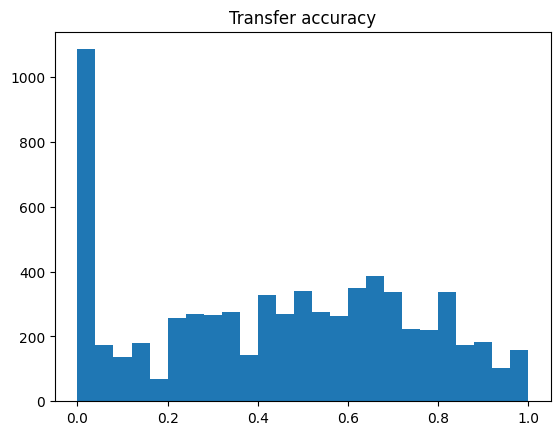

In [439]:
import matplotlib.pyplot as plt
plt.hist(, bins=25)
plt.title("Transfer accuracy")
plt.show()

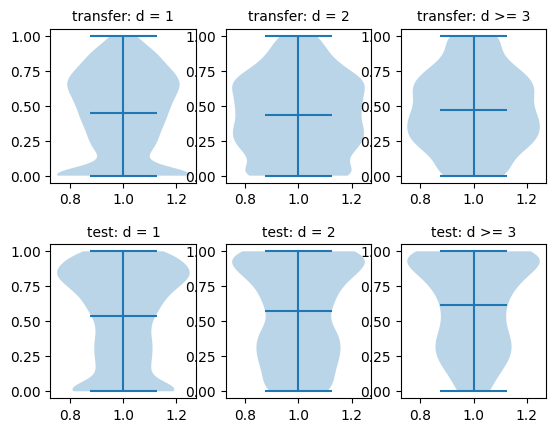

In [488]:
fig, axs = plt.subplots(nrows=2, ncols=3)
fs = 10
axs[0, 0].violinplot(acc_trans_dup1, showmeans=True)
axs[0, 0].set_title("transfer: d = 1", fontsize=fs)
axs[0, 1].violinplot(acc_trans_dup2, showmeans=True)
axs[0, 1].set_title("transfer: d = 2", fontsize=fs)
axs[0, 2].violinplot(acc_trans_dup3, showmeans=True)
axs[0, 2].set_title("transfer: d >= 3", fontsize=fs)

axs[1, 0].violinplot(acc_test_dup1, showmeans=True)
axs[1, 0].set_title("test: d = 1", fontsize=fs)
axs[1, 1].violinplot(acc_test_dup2, showmeans=True)
axs[1, 1].set_title("test: d = 2", fontsize=fs)
axs[1, 2].violinplot(acc_test_dup3, showmeans=True)
axs[1, 2].set_title("test: d >= 3", fontsize=fs)

fig.subplots_adjust(hspace=0.4)
plt.show()


In [6]:
# Clean the raw data
cleanData = clean(data)
# Load in duplicate crosswalk
duplicates = pd.read_csv("y2/duplicates.csv")
# Filter duplicates
filteredCleanData = processDuplicates(cleanData, duplicates)
# Convert filtered data from DF to dict
cleanData = pd.DataFrame.to_dict(filteredCleanData, orient="index")
# Get round-level data
rounds = getRounds(cleanData)

Dataset ready.


In [25]:
rounds.to_csv(csvPath, index=False)

In [17]:
Counter(filteredCleanData["completed"])

Counter({False: 6196, True: 6639})